# YOUTUBE ANTI-SCAM ANALYTICS

## Introduction

Althought youtube is an incredible source of knowledge and enternaining it has some big problems. At this moment, Youtube has not a final solution for scam comments in their videos, making unsafe and also irritating to go throught them. To solve that a NLP model has been trained on scam comment, to can automatically detect and delete this comments using the youtube api.

In this notebook, a small sploratory analisys has been made to notice the impact of scam comments in channels. In orther to user the tool to automatically remove scam in your own channel, please refer to the README, and use the example script spamTool.py to get started.

All the process to train this model is provided at the notebook fineTuneModel.ipynb.

## Installing dependencies (Always remember to work in a virtual enviroment.)


In [1]:
install_dep = 1 # Set to 1 only the first time you run this application

if install_dep:
    !pip install numpy
    !pip install pandas
    !pip install datasets
    !pip install torch
    !pip install scikit-learn
    !pip install python-dotenv
    !pip install google-api-python-client==1.7.2
    !pip install google-auth==1.8.0
    !pip install google-auth-httplib2==0.0.3
    !pip install google-auth-oauthlib==0.4.1
    
    !pip install seaborn
    !pip install isodate

    !pip install transformers
    !pip install xformers
    !pip install sentencepiece
    !pip install protobuf==3.20.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 4.4 MB/s eta 0:00:00m eta 0:00:010:00:01


In [2]:
import os
from dotenv import load_dotenv
from googleapiclient.discovery import build
import pandas as pd
#from fastai.tabular.all import *
from IPython.display import JSON

# Data visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Custom functions for youtube API
import youtube_API as youApi

## Youtube API interface

To use the youtube API, you need to create a project for developers. In this case it is used load_dotenv library to keep the key in a safe way outside the repo. Feel free to use any method, just be carefull to don't share the key.

In this case we take a channel focused on crypto coins, just becouse it is more suitable to contain tons of spam and scam messages.

In [3]:
load_dotenv()
api_key = os.getenv('API_KEY')

In [4]:
channel_ids = ['UCGDjpwZV-bU-sLSnhInCfKQ']

In [5]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API clien
youtube = build(
    api_service_name, api_version, developerKey=api_key)

### Channel data

We need to retreive the data from the channel to can find the comments and execute our analysis. Analytical data will be helpfull to perform a exploratory analisys over the scam characteristics.

In [6]:
channel_stats = youApi.get_channel_stats(youtube, channel_ids)

In [7]:
playlist_id = channel_stats.playlistId[0]

In [8]:
video_ids = youApi.get_video_ids(youtube, playlist_id)

In [9]:
video_df = youApi.get_video_details(youtube, video_ids)

### Get video comments

The mayor goal of this project is to detect scam in comments, so we need to obtain the comments from youtube api. Once we have all the comments, we are going to pass them througt our hugging face neural network fine tunned for scam detection.

In [10]:
videos_id = video_df['video_id'][0]
df = youApi.get_comments_in_videos(youtube, videos_id)

## Load finetuned model

In [12]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TextClassificationPipeline

/home/jorge/repos/youtubescamdetector/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
finetuned = './training/model'
tokenizer = AutoTokenizer.from_pretrained(finetuned)
model_ = AutoModelForSequenceClassification.from_pretrained(finetuned)
pipe = TextClassificationPipeline(model=model_, tokenizer=tokenizer, top_k = None)

## Analyze comments to label them as spam

This actually already allow us to use youtube-API to mark videos as spam. Here is an example of how to do it for this specific video.

In [14]:
temp = pipe(list(df.text), top_k=None)
scam_list = np.array([d[0]['score'] if d[0]['label'] == 'LABEL_1' else 1 - d[0]['score'] for d in temp])
scam_list

array([5.34832478e-04, 3.22103500e-04, 3.74686718e-03, 9.95137513e-01,
       1.88291073e-03, 2.05457211e-04, 8.80062580e-04, 1.52748227e-02,
       6.82532132e-01, 8.10563564e-04, 2.93791294e-04])

As we saw at training, under 0.8 probability of spam, some legit messages are marked as spam. Just to be more conservative and try to don't remove legit comments, we will only mark as spam messages that are above a threshold of 0.9. This is easily customizable.

In [15]:
scam_list = scam_list>0.9
df['scam'] = scam_list
df.head()

comment_id     video_id                  authorId  \
0  UgxBqHlR4h1rTUxUnRB4AaABAg  NDUKEkdMHWk  UCr0RbmxeQ7Ae6zbiHIKVlTQ   
1  Ugw1c7ldiTigYf4Z6gh4AaABAg  NDUKEkdMHWk  UCIminO5QJ_wlwExkcKvp28Q   
2  UgzeOg3Z7UCHIUALdfB4AaABAg  NDUKEkdMHWk  UCiutMmcp_rVTGKR9ivltLrA   
3  Ugw0ANdRkmHjuf4W57N4AaABAg  NDUKEkdMHWk  UCumNBZkAgb7rJSkQpT_g6cw   
4  UgzEvqghHQS9l_QAI7Z4AaABAg  NDUKEkdMHWk  UCKzgfWpp0PBeXqHMSyUztgA   

               authorName           publishedAt parentId  \
0           BoBBy Freedom  2023-06-03T10:00:45Z     none   
1            The Mrokspok  2023-06-03T09:48:16Z     none   
2  Mirchy WannaBeaDrummer  2023-06-03T09:42:29Z     none   
3         Stephanie Coker  2023-06-03T09:28:50Z     none   
4              Tomaž Verč  2023-06-03T09:09:16Z     none   

                                                text   scam  
0                                show bots criteria   False  
1         Because its obvious upside we go downside.  False  
2  Surely at this point institutions will not be ...  False  
3  please 🙏how can I be profitable in crypto trading   True  
4  Thats why we are here to found out when is goi...  False

## Spam statistics

We are going to do some exploratory analysis about the spam, in order to extract helpful information about it that may could allow us to improve our strategies against it. At first, getting all comments from a channel could be just too much, so we need to work with random subsets of videos and comments. We also are going to save the dataframe obtained from youtube, just to avoid unnecesary use of the API which could potencially reach the free use limit.

In [16]:
videos_ids = list(video_df['video_id'].sample(n=100))
random_comments = youApi.random_comments(youtube, videos_ids, n=150)
random_comments.head()

comment_id     video_id                  authorId  \
0  UgzQE5ZkMv3eJoizBPR4AaABAg  wGMFmHWiuio  UC9Xl_5ySWGrhiI6SJ1kCGFg   
1  Ugwqq7iBx02V9Og2b-Z4AaABAg  wGMFmHWiuio  UCqiICtemMhmwT_YpA-43DkA   
2  UgwnUTWFn3fAh_6kcFd4AaABAg  wGMFmHWiuio  UCQf3qq-0h8vpiEYFO-MGu0w   
3  UgyhyAcsmOEb28YHoih4AaABAg  wGMFmHWiuio  UCFlmP_Jfh6ORLr8nt2MoIhw   
4  UgyDKpHB8pKePdpaKR14AaABAg  wGMFmHWiuio  UC8uf_kgjV8ZuR88vqb7pKYA   

      authorName           publishedAt parentId  \
0   Damian Sobik  2021-12-11T21:33:46Z     none   
1  Anaël Leinert  2021-12-11T13:04:54Z     none   
2       Flangler  2021-12-11T07:06:32Z     none   
3    Destiny Kid  2021-12-11T03:11:47Z     none   
4       Uni Mail  2021-12-10T15:31:52Z     none   

                                                text  
0  What if the "whale"  adress is a exchange cold...  
1  I don't care about predictions, I care about b...  
2  What about the comparison with gold which you ...  
3  Stop fooling man, Just check BTC price action ...  
4  He ignores his own charts... on nupl chart... ...

In [17]:
random_comments.video_id.value_counts()

video_id
983SQuBub3E    150
C8elAs_4Vj0    150
_J_d95G_gb8    150
ycSS7mFZEIc    150
X-ixzIV55mA    150
              ... 
Ov5o1orB_O4     18
aHs36QXve3Q     12
oVsiuvUNIcg      9
P3KVvB78L1U      8
xClVeXQ7AkU      4
Name: count, Length: 100, dtype: int64

In [18]:
temp = pipe(list(random_comments.text), top_k=None)
scam_list = np.array([d[0]['score'] if d[0]['label'] == 'LABEL_1' else 1 - d[0]['score'] for d in temp])
scam_list = scam_list>0.95
random_comments['scam'] = scam_list
random_comments.describe(include='object')

comment_id     video_id                  authorId  \
count                         7775         7775                      7775   
unique                        7775          100                      5935   
top     UgzQE5ZkMv3eJoizBPR4AaABAg  983SQuBub3E  UCF-j1B0XXBD_DzrGdeV9oww   
freq                             1          150                        55   

       authorName           publishedAt parentId   text  
count        7775                  7775     7775   7775  
unique       5868                  7673        1   7353  
top       R James  2020-11-23T12:48:03Z     none  First  
freq           55                     5     7775     32

## Data pre-processing

In [19]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [20]:
from dateutil import parser

In [21]:
# Publish day of the week
try:
    video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
    video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))
except:    
    pass

In [22]:
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [23]:
#Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

<Axes: >

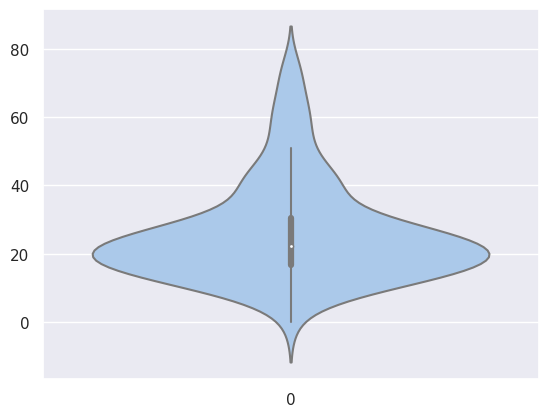

In [24]:
scam_count = []
for i in videos_ids:
    scam_count.append(sum(random_comments.loc[random_comments.video_id==i].scam)
        /len(random_comments.loc[random_comments.video_id==i])* 100) 
sns.violinplot(scam_count, palette = 'pastel')

In [25]:
try:
    random_comments['publishedAt'] = random_comments['publishedAt'].apply(lambda x: parser.parse(x))
    random_comments['publishDayName'] = random_comments['publishedAt'].apply(lambda x: x.strftime("%A"))

except:
    pass

In [26]:
temp_date = (
    random_comments.loc[random_comments['video_id'] == videos_ids[0]].publishedAt.values -
    video_df.loc[video_df['video_id'] == i].publishedAt.values
    )
              
for i in videos_ids[1:]:
    temp_date = np.append(temp_date,
        random_comments.loc[random_comments['video_id'] == i].publishedAt.values -
        video_df.loc[video_df['video_id'] == i].publishedAt.values
    )     
    
random_comments['days_delay'] = temp_date
random_comments['days_delay'] = random_comments['days_delay'].dt.days

Text(3044.76, 26.091903826692732, '-0.007')

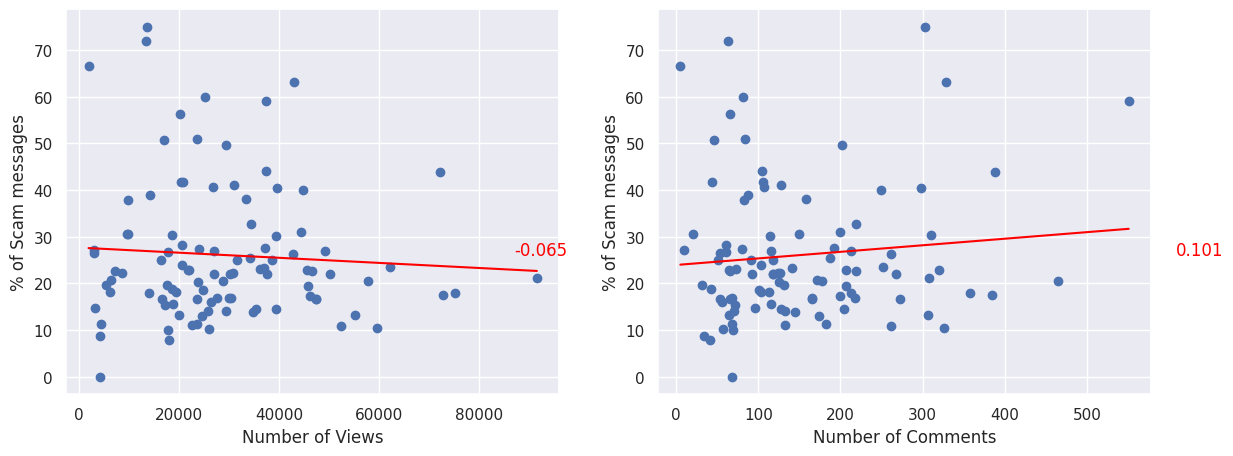

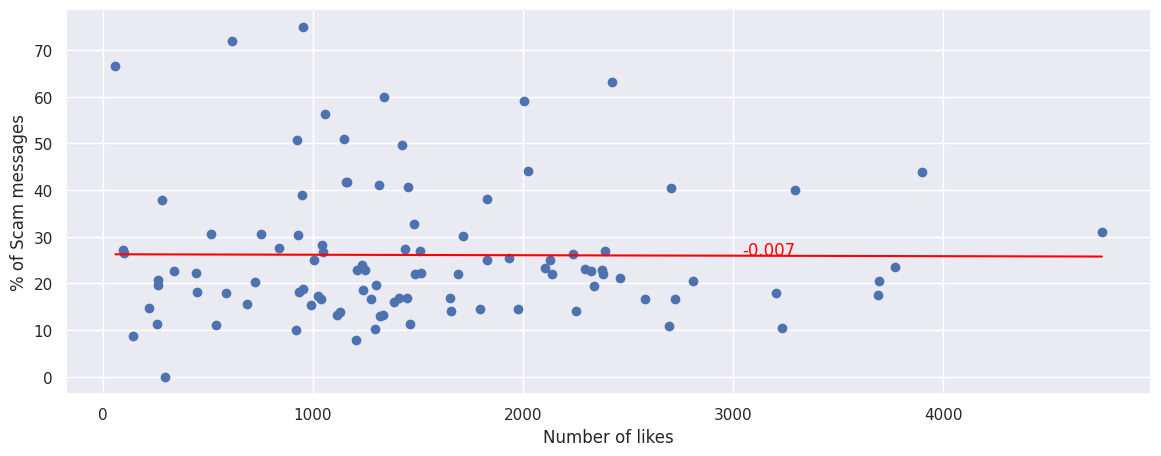

In [27]:
r = [] #Correlation coefficient

# FIGURE 1
# ===========================================================================
plt.rcParams['figure.figsize'] = [14, 5]
fig, [ax1,ax2] = plt.subplots(1,2)

temp_df = video_df.loc[video_df['video_id'].isin(videos_ids)].viewCount.values

ax1.scatter(temp_df,scam_count);
ax1.set_ylabel('% of Scam messages')
ax1.set_xlabel('Number of Views')

temp = np.corrcoef(temp_df, scam_count)
r.append(temp[0,1])

# Calculate linear regression
slope, intercept = np.polyfit(temp_df, scam_count, 1)
x = np.array([min(temp_df), max(temp_df)])
y = slope * x + intercept

# Add linear regression line
ax1.plot(x, y, color='red')

# Add correlation value over the line
ax1.text(np.mean(temp_df)*3, np.mean(scam_count), f'{r[0]:.3f}', color='red')


# FIGURE 2
# ===========================================================================
temp_df = video_df.loc[video_df['video_id'].isin(videos_ids)].commentCount.values

ax2.scatter(temp_df,scam_count);
ax2.set_ylabel('% of Scam messages')
ax2.set_xlabel('Number of Comments')

temp = np.corrcoef(temp_df, scam_count)
r.append(temp[0,1])

# Calculate linear regression
slope, intercept = np.polyfit(temp_df, scam_count, 1)
x = np.array([min(temp_df), max(temp_df)])
y = slope * x + intercept

# Add linear regression line
ax2.plot(x, y, color='red')

# Add correlation value over the line
ax2.text(np.mean(temp_df)*4, np.mean(scam_count), f'{r[1]:.3f}', color='red')

# FIGURE 3
# ===========================================================================
fig, ax1 = plt.subplots()
temp_df = video_df.loc[video_df['video_id'].isin(videos_ids)].likeCount.values

ax1.scatter(temp_df,scam_count);
ax1.set_ylabel('% of Scam messages')
ax1.set_xlabel('Number of likes')

temp = np.corrcoef(temp_df, scam_count)
r.append(temp[0,1])

# Calculate linear regression
slope, intercept = np.polyfit(temp_df, scam_count, 1)
x = np.array([min(temp_df), max(temp_df)])
y = slope * x + intercept

# Add linear regression line
ax1.plot(x, y, color='red')

# Add correlation value over the line
ax1.text(np.mean(temp_df)*2, np.mean(scam_count), f'{r[2]:.3f}', color='red')


From the scatter plot it seems that there is not a clear relation between the number of views of a video and the percentaje of spam messages.

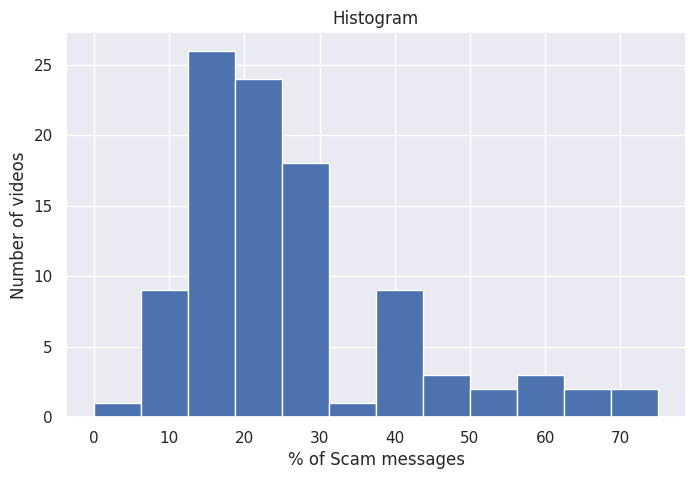

In [28]:
num_bins = 12
plt.rcParams['figure.figsize'] = [8, 5]
fig, ax = plt.subplots()
n, bins, patches = ax.hist(scam_count, num_bins, density=False)
ax.set_xlabel('% of Scam messages')
ax.set_ylabel('Number of videos')
ax.set_title('Histogram');

Finally it is interesting to analyze if there is a relation between the date and the spam creation. The 2 question we want to answer are:

1. ¿Is there any thay of the week were more spam is created?
2. ¿Is the spam created in a certain timeframe after the release of the video?

Text(0.5, 1.0, 'Spam ratio each day')

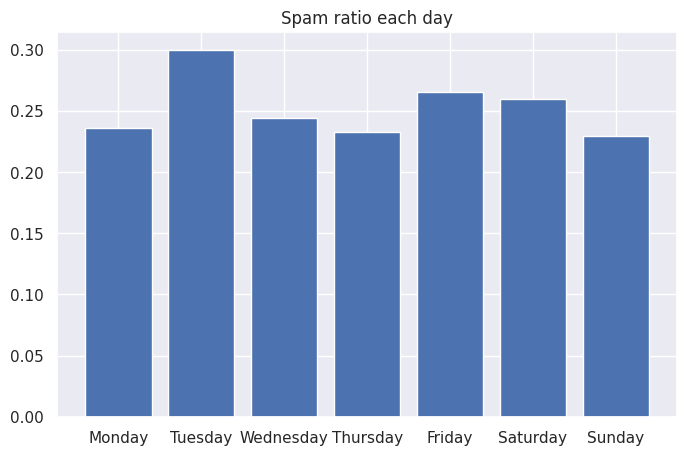

In [29]:
# Spam messages every day of the week.
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
total_byDay = random_comments['publishDayName'].value_counts()
spam_byDay = random_comments.loc[random_comments["scam"]==True]["publishDayName"].value_counts()

spamRatioByDay = spam_byDay.reindex(weekdays)/total_byDay.reindex(weekdays)
                                   
fig, ax = plt.subplots()                           
ax.bar(weekdays, spamRatioByDay)
ax.set_title("Spam ratio each day")

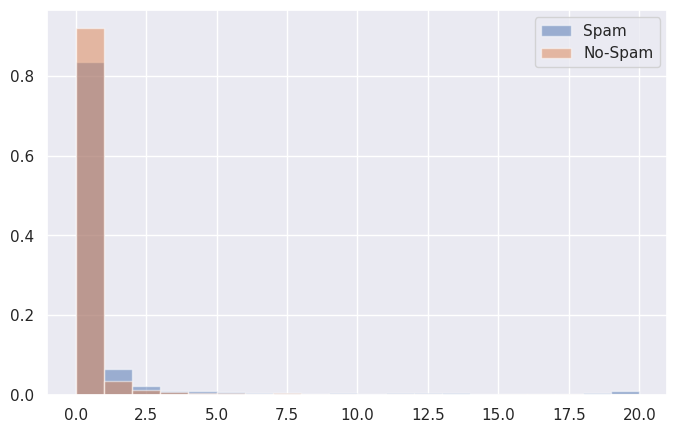

In [30]:
# Days between message and video-creation
random_comments.head()
fig, ax = plt.subplots()
num_bins = 20
n, bins, patches = (
    ax.hist(random_comments.loc[random_comments['scam']].days_delay,
    num_bins, range=[0, 20], density=True, alpha=0.5, label='Spam')
)

n, bins, patches = (
    ax.hist(random_comments.loc[random_comments['scam']==False].days_delay, 
    num_bins, range=[0, 20], density=True, alpha=0.5, label='No-Spam')
)

ax.legend()

Unfortunatly this small analysis have not shown any important finding in the scam comments behaviour. NEverless it is a good starting point to continue improving this project and try to find which data would be more interesting to train more complex and acurate models.